In [51]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from torchvision import transforms

#load in data
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_train = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=False)
mnist_test = torchvision.datasets.MNIST(root=image_path, train=False, transform=transform, download=False)

#create validation set using 5000 examples from the training set
n_train = 55000
x_train = mnist_train.data[:n_train, :, :].float()
y_train = mnist_train.targets[:n_train]
x_valid = mnist_train.data[n_train:, :, :].float()
y_valid = mnist_train.targets[n_train:]

#create TensorDataset object
train_ds = TensorDataset(x_train, y_train)

#create DataLoader object
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

Above, we constructed a `DataLoader` object with batches of $64$ samples. The `ToTensor(`) method converted the pixel features into a floating type tensor and normalized the pixels from the interval $[0, 255]$ to $[0, 1]$, so there is no need to further preprocess our features.

Below, we construct the neural network model we will use to predict the MNIST dataset.

In [52]:
#define general dimensions for model
hidden_units = [64, 32, 16]
image_size = mnist_train[0][0].shape
input_size = image_size[0] * image_size[1] * image_size[2]

#start the model with a flatten layer to turn input image into a 1d tensor
all_layers = [nn.Flatten()]

#for the dimensions we defined above, append a layer to the neural network with ReLU activation
for hidden_size in hidden_units:
    layer = nn.Linear(input_size, hidden_size)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_size

#finally, add output layer of 10 units
all_layers.append(nn.Linear(input_size, 10))

#define model by unpacking list of layers
model = nn.Sequential(*all_layers)
model

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Linear(in_features=32, out_features=16, bias=True)
  (6): ReLU()
  (7): Linear(in_features=16, out_features=10, bias=True)
)

In [53]:
#define cross-entropy loss function
loss_fn = nn.CrossEntropyLoss()

#define Adam optimizer with learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#define training loop
def train(model, num_epochs, train_dl, x_valid, y_valid):
    #set up outputs of function (return training loss and accuracy and validation loss and accuracy)
    loss_hist_train = [0] * num_epochs
    acc_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    acc_hist_valid = [0] * num_epochs
    
    #implement training loop
    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            #generate predictions
            pred = model(x_batch)
            
            #calculate loss
            loss = loss_fn(pred, y_batch)
            
            #compute gradients
            loss.backward()
            
            #update parameters using gradients
            optimizer.step()
            
            #reset the gradients to zero
            optimizer.zero_grad()
            
            #add up the training loss and accuracy for each batch
            loss_hist_train[epoch] += loss.item()
            is_acc = (torch.argmax(pred, dim=1) == y_batch).float()
            acc_hist_train[epoch] += is_acc.mean()
        
        #calculate training loss and accuracy over the epoch
        loss_hist_train[epoch] /= (n_train/batch_size)
        acc_hist_train[epoch] /= (n_train/batch_size)
        
        #use the newly trained model to predict the validation set
        pred = model(x_valid)
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_acc = (torch.argmax(pred, dim=1) == y_valid).float()
        acc_hist_valid[epoch] = is_acc.mean()
        
    return loss_hist_train, loss_hist_valid, acc_hist_train, acc_hist_valid

In [54]:
#train the model for 20 epochs
torch.manual_seed(1)
num_epochs = 20
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Now, we plot the learning curves for the cross-entropy loss and the classification accuracy.

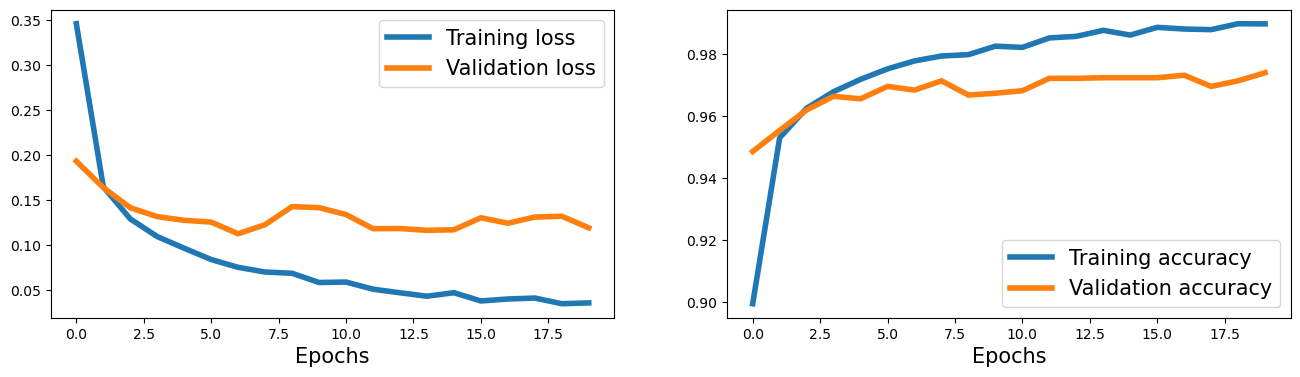

In [55]:
import matplotlib.pyplot as plt

#set up figures
fig = plt.figure(figsize=(16, 4))

#plot cross-entropy loss learning curves (training and validation) on same set of axes
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Training loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#plot classification accuracy learning curves (training and validation) on same set of axes
ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Training accuracy', 'Validation accuracy'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

plt.show()

In [61]:
#evaluate model on test set
pred = model(mnist_test.data.float())
is_acc = (torch.argmax(pred, dim=1) == mnist_test.targets).float()
print(f'Test accuracy: {is_acc.mean():.4f}')

Test accuracy: 0.9718


Looking at the performance of the model on the test set, it appears that the model is slightly overfitting. To address this:
 - implement learning curves (training and validation) to visualize performance
 - include early stopping, stop training once validation peaks
 - implement a NoisyLinear layer

Early stopping criterion is: if the training is not resulting in lowering of the validation loss then terminate it. Here's an example implementation:

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=3, min_delta=10)
for epoch in np.arange(n_epochs):
    train_loss = train_one_epoch(model, train_loader)
    validation_loss = validate_one_epoch(model, validation_loader)
    if early_stopper.early_stop(validation_loss):             
        break